<a href="https://colab.research.google.com/github/1021114Carlos/risk-free-assets-to-generate-income/blob/main/risk_free_assets_to_generate_income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
from dataclasses import dataclass
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional


In [1]:
"""
T-Bill Ladder Strategy Simulator (Schwab-style $1000 increments)

What this does:
- You pay a fixed monthly debt payment (0% debt interest assumed).
- You also contribute a fixed monthly amount to a "bond-buying cash bucket".
- When the cash bucket reaches enough to fund your chosen purchase plan (in $1000 increments),
  the simulator buys those T-bills (rungs) at that month.
- Each rung matures after its term (3, 5, 6, 7, 9, etc. months) and produces proceeds.
- Proceeds go into an "available cash" bucket that can be used to make monthly debt payments.
- The simulator prints:
  1) A month-by-month table (debt, contributions, purchases, maturities, payments)
  2) A maturity table showing proceeds per rung and totals by maturity month.

Important:
- T-bills don't generate $250/month of *interest*. This works by using principal + interest.
- Yield is modeled as AFTER-FED-tax monthly compounding for simplicity.

You can customize:
- monthly_debt_payment
- monthly_invest_contribution
- debt_balance
- purchase plan (amount per maturity term; must be multiples of $1000)
- yield and taxes
- whether you keep investing after "handoff"
"""

# -----------------------------
# Helpers
# -----------------------------

def parse_purchase_plan(plan_str: str) -> Dict[int, float]:
    """
    Parse a purchase plan string like:
      "3:1000,5:1000,7:2000"
    meaning:
      - buy $1000 face of 3-month
      - buy $1000 face of 5-month
      - buy $2000 face of 7-month

    Returns dict {term_months: face_amount}.
    """
    plan_str = plan_str.strip()
    if not plan_str:
        raise ValueError("Purchase plan cannot be empty.")

    plan: Dict[int, float] = {}
    parts = [p.strip() for p in plan_str.split(",") if p.strip()]
    for p in parts:
        if ":" not in p:
            raise ValueError(f"Bad plan item '{p}'. Use 'term:amount' like '3:1000'.")
        term_s, amt_s = [x.strip() for x in p.split(":", 1)]
        term = int(term_s)
        amt = float(amt_s)
        if term <= 0:
            raise ValueError("Term months must be positive.")
        if amt <= 0:
            raise ValueError("Amount must be positive.")
        if abs(amt % 1000) > 1e-9:
            raise ValueError(f"Amount {amt} must be a multiple of 1000 (Schwab minimum increments).")
        plan[term] = plan.get(term, 0.0) + amt

    return plan


def after_tax_monthly_rate(nominal_annual_yield: float, fed_tax_rate: float) -> float:
    """
    Treasuries: exempt from state/local, taxable federally.
    Use simple after-tax annual yield => divide by 12.
    """
    if nominal_annual_yield < 0:
        raise ValueError("Yield must be non-negative.")
    if not (0 <= fed_tax_rate <= 1):
        raise ValueError("Fed tax rate should be in [0,1].")
    return (nominal_annual_yield * (1 - fed_tax_rate)) / 12.0


def maturity_proceeds(face: float, r_m: float, term_months: int) -> float:
    """Model proceeds at maturity with monthly compounding at after-tax monthly rate."""
    return face * ((1.0 + r_m) ** term_months)


# -----------------------------
# Data structures
# -----------------------------

@dataclass
class Lot:
    term_months: int
    face: float
    buy_month: int
    maturity_month: int
    proceeds: float


# -----------------------------
# Simulation
# -----------------------------

def simulate_tbill_strategy(
    debt_balance: float,
    monthly_debt_payment: float,
    monthly_invest_contribution: float,
    purchase_plan: Dict[int, float],
    nominal_annual_yield: float = 0.04,
    fed_tax_rate: float = 0.22,
    keep_investing_after_handoff: bool = True,
    horizon_months: int = 240
) -> Tuple[pd.DataFrame, pd.DataFrame, dict]:
    """
    purchase_plan: dict {term_months: face_to_buy_when_triggered}
      Example: {3:1000, 5:1000, 7:2000} means every time you have enough cash,
      you buy those rungs together as a "batch".

    Trigger rule:
      - Let batch_cost = sum(face amounts) (must be multiple of 1000).
      - If cash_bucket >= batch_cost at month end, buy ONE batch (repeat if enough for multiple batches).

    Cash buckets:
      - cash_bucket: accumulates monthly contributions (for buying)
      - available_cash: receives maturity proceeds and can pay debt

    Payment rule:
      - Each month, due = min(monthly_debt_payment, remaining_debt)
      - Pay from available_cash first
      - Any remaining due is paid from income (not tracked as a separate bucket—just logged)

    Returns:
      - monthly_df: month-by-month table
      - maturities_df: per-lot maturity table + grouped totals
      - summary: dict with handoff_month and totals
    """
    if debt_balance <= 0:
        raise ValueError("Debt balance must be positive.")
    if monthly_debt_payment <= 0:
        raise ValueError("Monthly debt payment must be positive.")
    if monthly_invest_contribution < 0:
        raise ValueError("Monthly invest contribution cannot be negative.")
    if horizon_months <= 0:
        raise ValueError("Horizon must be positive.")

    # validate purchase_plan amounts are multiples of 1000
    if not purchase_plan:
        raise ValueError("Purchase plan is empty.")
    for t, a in purchase_plan.items():
        if t <= 0:
            raise ValueError("All term months must be positive.")
        if a <= 0:
            raise ValueError("All plan amounts must be positive.")
        if abs(a % 1000) > 1e-9:
            raise ValueError("All plan amounts must be multiples of $1000.")

    r_m = after_tax_monthly_rate(nominal_annual_yield, fed_tax_rate)
    batch_cost = sum(purchase_plan.values())

    cash_bucket = 0.0
    available_cash = 0.0
    lots: List[Lot] = []

    handoff_month: Optional[int] = None

    rows = []

    remaining_debt = debt_balance

    for month in range(1, horizon_months + 1):
        if remaining_debt <= 1e-9:
            break

        start_debt = remaining_debt
        start_cash_bucket = cash_bucket
        start_available_cash = available_cash

        # contribution (optionally stop after handoff)
        contribute = monthly_invest_contribution
        if handoff_month is not None and not keep_investing_after_handoff:
            contribute = 0.0

        cash_bucket += contribute

        # maturities this month
        matured = [lot for lot in lots if lot.maturity_month == month]
        maturity_inflow = sum(lot.proceeds for lot in matured)
        if matured:
            lots = [lot for lot in lots if lot.maturity_month != month]
        available_cash += maturity_inflow

        # monthly debt payment
        due = min(monthly_debt_payment, remaining_debt)

        paid_from_assets = min(due, available_cash)
        available_cash -= paid_from_assets

        paid_from_income = due - paid_from_assets  # whatever isn't covered by assets
        remaining_debt -= due
        remaining_debt = max(remaining_debt, 0.0)

        # detect handoff: first month where assets covered full due while debt still remains after payment
        if handoff_month is None and paid_from_income <= 1e-9 and remaining_debt > 1e-9:
            handoff_month = month

        # purchases: buy as many whole batches as possible
        batches_bought = 0
        lots_bought_this_month = 0
        while cash_bucket + 1e-9 >= batch_cost:
            # buy one batch
            for term_m, face in purchase_plan.items():
                lot = Lot(
                    term_months=term_m,
                    face=face,
                    buy_month=month,
                    maturity_month=month + term_m,
                    proceeds=maturity_proceeds(face=face, r_m=r_m, term_months=term_m)
                )
                lots.append(lot)
                lots_bought_this_month += 1
            cash_bucket -= batch_cost
            batches_bought += 1

        rows.append({
            "Month": month,
            "StartDebt": start_debt,
            "DebtPaymentDue": due,
            "PaidFromAssets": paid_from_assets,
            "PaidFromIncome": paid_from_income,
            "EndDebt": remaining_debt,
            "InvestContribution": contribute,
            "StartCashBucket": start_cash_bucket,
            "EndCashBucket": cash_bucket,
            "StartAvailableCash": start_available_cash,
            "MaturityInflow": maturity_inflow,
            "EndAvailableCash": available_cash,
            "BatchesBought": batches_bought,
            "LotsBought": lots_bought_this_month,
            "LotsOutstanding": len(lots),
        })

    monthly_df = pd.DataFrame(rows)

    # Build maturity table from all lots ever created:
    # We didn't store "all lots" separately, so reconstruct by re-simulating purchases from the monthly table is messy.
    # Instead: during simulation, keep a separate list of all lots created.
    # For simplicity: re-run with a minor change is annoying; so we track all lots via a summary inside the loop.
    # We'll do it the right way: rebuild by adding a list in this function.

    # ---- Re-run quickly to collect all lots (small overhead, simple, deterministic) ----
    # (This keeps the main simulation clean and avoids complicating the loop.)
    all_lots: List[Lot] = []
    cash_bucket = 0.0
    available_cash = 0.0
    lots_live: List[Lot] = []
    remaining_debt = debt_balance
    handoff_seen = False

    for month in range(1, horizon_months + 1):
        if remaining_debt <= 1e-9:
            break

        contribute = monthly_invest_contribution
        if handoff_seen and not keep_investing_after_handoff:
            contribute = 0.0
        cash_bucket += contribute

        # maturities
        matured = [lot for lot in lots_live if lot.maturity_month == month]
        maturity_inflow = sum(lot.proceeds for lot in matured)
        if matured:
            lots_live = [lot for lot in lots_live if lot.maturity_month != month]
        available_cash += maturity_inflow

        # payment
        due = min(monthly_debt_payment, remaining_debt)
        paid_from_assets = min(due, available_cash)
        available_cash -= paid_from_assets
        paid_from_income = due - paid_from_assets
        remaining_debt -= due
        remaining_debt = max(remaining_debt, 0.0)

        if not handoff_seen and paid_from_income <= 1e-9 and remaining_debt > 1e-9:
            handoff_seen = True

        # purchases
        while cash_bucket + 1e-9 >= batch_cost:
            for term_m, face in purchase_plan.items():
                lot = Lot(
                    term_months=term_m,
                    face=face,
                    buy_month=month,
                    maturity_month=month + term_m,
                    proceeds=maturity_proceeds(face=face, r_m=r_m, term_months=term_m)
                )
                lots_live.append(lot)
                all_lots.append(lot)
            cash_bucket -= batch_cost

    maturities_df = pd.DataFrame([{
        "BuyMonth": lot.buy_month,
        "TermMonths": lot.term_months,
        "Face": lot.face,
        "MaturityMonth": lot.maturity_month,
        "ProceedsAtMaturity": lot.proceeds,
        "InterestEarned": lot.proceeds - lot.face
    } for lot in all_lots])

    if len(maturities_df) == 0:
        maturity_totals = pd.DataFrame(columns=["MaturityMonth", "TotalFaceMaturing", "TotalProceeds", "TotalInterest"])
    else:
        maturity_totals = (maturities_df
                           .groupby("MaturityMonth", as_index=False)
                           .agg(TotalFaceMaturing=("Face", "sum"),
                                TotalProceeds=("ProceedsAtMaturity", "sum"),
                                TotalInterest=("InterestEarned", "sum"))
                           .sort_values("MaturityMonth"))

    summary = {
        "handoff_month": handoff_month,
        "months_simulated": int(monthly_df["Month"].max()) if len(monthly_df) else 0,
        "total_paid_from_income": float(monthly_df["PaidFromIncome"].sum()) if len(monthly_df) else 0.0,
        "total_paid_from_assets": float(monthly_df["PaidFromAssets"].sum()) if len(monthly_df) else 0.0,
        "assumed_nominal_annual_yield": nominal_annual_yield,
        "after_tax_monthly_rate_used": r_m,
        "batch_cost": batch_cost,
        "purchase_plan": dict(purchase_plan),
    }

    return monthly_df, maturities_df, maturity_totals, summary


# -----------------------------
# CLI Runner
# -----------------------------

def main():
    print("\n=== T-Bill Ladder Strategy Simulator ===\n")

    debt_balance = float(input("Debt balance owed (e.g., 12343.04): ").strip())
    monthly_debt_payment = float(input("Monthly debt payment (e.g., 250): ").strip())
    monthly_invest_contribution = float(input("Monthly amount you will set aside to buy T-bills (e.g., 250): ").strip())

    print("\nPurchase plan format: term_months:amount,term_months:amount ...")
    print("Examples:")
    print("  3:1000,5:1000,7:1000")
    print("  3:2000,5:2000")
    plan_str = input("Enter your purchase plan: ").strip()
    purchase_plan = parse_purchase_plan(plan_str)

    nominal_yield = float(input("\nNominal annual yield assumption (e.g., 0.04 for 4%): ").strip())
    fed_tax_rate = float(input("Federal tax rate (e.g., 0.22): ").strip())

    keep_investing = input("Keep investing after handoff? (y/n): ").strip().lower() in ("y", "yes", "1", "true")

    horizon = input("Max months to simulate (default 240): ").strip()
    horizon_months = int(horizon) if horizon else 240

    monthly_df, lots_df, maturity_totals_df, summary = simulate_tbill_strategy(
        debt_balance=debt_balance,
        monthly_debt_payment=monthly_debt_payment,
        monthly_invest_contribution=monthly_invest_contribution,
        purchase_plan=purchase_plan,
        nominal_annual_yield=nominal_yield,
        fed_tax_rate=fed_tax_rate,
        keep_investing_after_handoff=keep_investing,
        horizon_months=horizon_months
    )

    print("\n=== SUMMARY ===")
    print(f"Purchase batch cost: {summary['batch_cost']:.2f}")
    print(f"After-tax monthly rate used: {summary['after_tax_monthly_rate_used']:.8f}")
    if summary["handoff_month"] is None:
        print("Handoff month: NOT reached within horizon.")
    else:
        print(f"Handoff month: {summary['handoff_month']} (first month assets cover full payment while debt remains)")
    print(f"Total paid from income: {summary['total_paid_from_income']:.2f}")
    print(f"Total paid from assets: {summary['total_paid_from_assets']:.2f}")
    print(f"Months simulated: {summary['months_simulated']}")

    # Show tables
    pd.set_option("display.width", 180)
    pd.set_option("display.max_columns", 40)

    print("\n=== MONTH-BY-MONTH TABLE (first 36 months) ===")
    print(monthly_df.head(36).to_string(index=False))

    print("\n=== MATURITY LOTS TABLE (all rungs bought) ===")
    if len(lots_df) == 0:
        print("(No purchases occurred. Increase monthly invest amount or reduce batch cost.)")
    else:
        print(lots_df.to_string(index=False))

    print("\n=== MATURITY TOTALS BY MONTH ===")
    if len(maturity_totals_df) == 0:
        print("(No maturities.)")
    else:
        print(maturity_totals_df.to_string(index=False))

    # Optional: export CSV
    export = input("\nExport CSVs? (y/n): ").strip().lower() in ("y", "yes", "1", "true")
    if export:
        monthly_df.to_csv("tbill_monthly_schedule.csv", index=False)
        lots_df.to_csv("tbill_lots.csv", index=False)
        maturity_totals_df.to_csv("tbill_maturity_totals.csv", index=False)
        print("Exported: tbill_monthly_schedule.csv, tbill_lots.csv, tbill_maturity_totals.csv")


if __name__ == "__main__":
    main()



=== T-Bill Ladder Strategy Simulator ===

Debt balance owed (e.g., 12343.04): 12343
Monthly debt payment (e.g., 250): 250
Monthly amount you will set aside to buy T-bills (e.g., 250): 250

Purchase plan format: term_months:amount,term_months:amount ...
Examples:
  3:1000,5:1000,7:1000
  3:2000,5:2000
Enter your purchase plan: 3:2000,5:2000

Nominal annual yield assumption (e.g., 0.04 for 4%): 0.04
Federal tax rate (e.g., 0.22): .22
Keep investing after handoff? (y/n): y
Max months to simulate (default 240): 240

=== SUMMARY ===
Purchase batch cost: 4000.00
After-tax monthly rate used: 0.00260000
Handoff month: 19 (first month assets cover full payment while debt remains)
Total paid from income: 4500.00
Total paid from assets: 7843.00
Months simulated: 50

=== MONTH-BY-MONTH TABLE (first 36 months) ===
 Month  StartDebt  DebtPaymentDue  PaidFromAssets  PaidFromIncome  EndDebt  InvestContribution  StartCashBucket  EndCashBucket  StartAvailableCash  MaturityInflow  EndAvailableCash  Batc

=== T-Bill Ladder Simulator (0% debt interest, Schwab $1000 min) ===
Debt balance owed (e.g., 12343.04): 12343.04
Monthly debt payment (e.g., 250): 250
Monthly amount you can set aside for T-bills (e.g., 250): 250
Minimum purchase per rung (Schwab usually 1000): 1000
Maturity cycle in months (e.g., 3,6,9 or 5,7,9 or 3,5,7,9,11): 3,5,7,9
Nominal annual yield (e.g., 0.04 for 4%): 0.04
Federal tax rate (e.g., 0.22): .22
Max months to simulate (e.g., 120): 120

=== RESULTS ===
After-tax monthly rate used: 0.0026
Months simulated: 50
Handoff month: 7 (first month ladder covers the full payment while debt remains)

TOTAL income NOT spent on debt because of the ladder (Income Saved):
9863.93

Sanity check totals (should add up to total paid):
Total paid from income: 2479.11
Total paid from ladder: 9863.93
Total debt repaid: 12343.04


,Month,StartDebt,PaymentDue,PaidFromAssets,PaidFromIncome,IncomeSavedThisMonth,EndDebt,InvestContribution,BondCashEnd,MaturityInflow,AvailableCashEnd,RungsBought,RungsOutstanding
0,1,12343.04,250.0,0.000000,250.000000,0.000000,12093.04,250.0,250.0,0.000000,0.000000,0,0
1,2,12093.04,250.0,0.000000,250.000000,0.000000,11843.04,250.0,500.0,0.000000,0.000000,0,0
2,3,11843.04,250.0,0.000000,250.000000,0.000000,11593.04,250.0,750.0,0.000000,0.000000,0,0
3,4,11593.04,250.0,0.000000,250.000000,0.000000,11343.04,250.0,0.0,0.000000,0.000000,1,1
4,5,11343.04,250.0,0.000000,250.000000,0.000000,11093.04,250.0,250.0,0.000000,0.000000,0,1
5,6,11093.04,250.0,0.000000,250.000000,0.000000,10843.04,250.0,500.0,0.000000,0.000000,0,1
6,7,10843.04,250.0,250.000000,0.000000,250.000000,10593.04,250.0,750.0,1007.820298,757.820298,0,0
7,8,10593.04,250.0,250.000000,0.000000,250.000000,10343.04,250.0,0.0,0.000000,507.820298,1,1
8,9,10343.04,250.0,250.000000,0.000000,250.000000,10093.04,250.0,250.0,0.000000,257.820298,0,1
9,10,10093.04,250.0,250.000000,0.000000,250.000000,9843.04,250.0,500.0,0.000000,7.820298,0,1


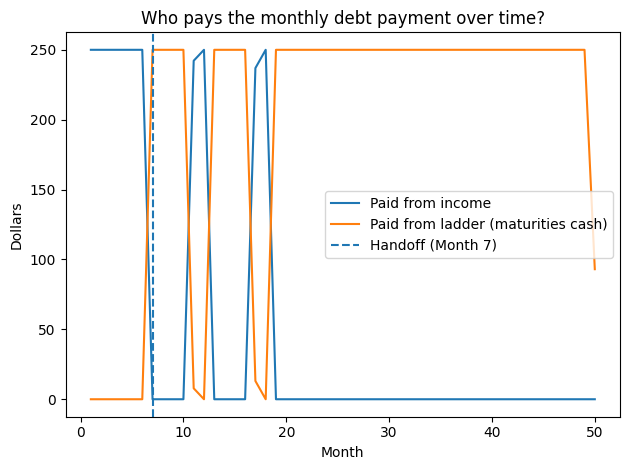

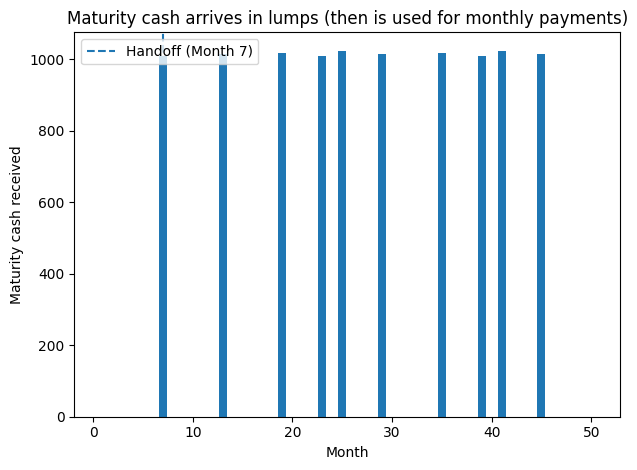

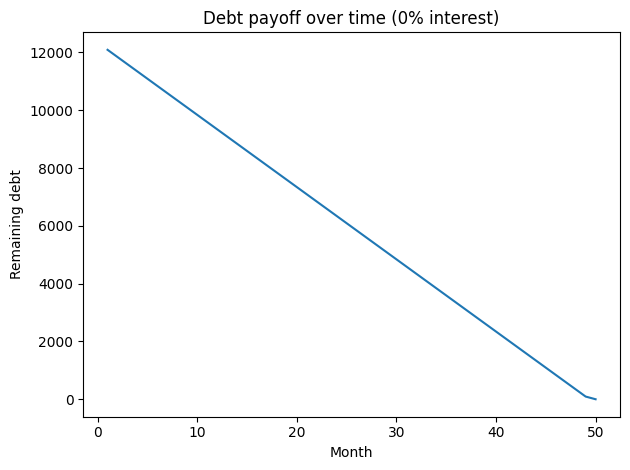

In [6]:
# ✅ COLAB-READY (USER INPUT + SAVINGS TOTAL + VISUALS)
# Paste into ONE Colab cell and run.
# This version:
# - asks for user inputs
# - simulates a T-bill ladder with Schwab $1000 minimum per rung
# - shows the handoff month
# - computes TOTAL "income saved" (months where ladder paid the debt)
# - shows tables + 3 visuals inline (no file paths needed)

import math
from dataclasses import dataclass
from typing import List, Tuple
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Utilities
# ----------------------------

def parse_cycle(s: str) -> Tuple[int, ...]:
    """
    Parse maturity cycle input like:
      "3,6,9"
      "5,7,9"
      "3,5,7,9,11"
    """
    parts = [p.strip() for p in s.split(",") if p.strip()]
    if not parts:
        raise ValueError("Maturity cycle cannot be empty.")
    cycle = tuple(int(p) for p in parts)
    if any(t <= 0 for t in cycle):
        raise ValueError("All maturities must be positive integers (months).")
    return cycle

def after_tax_monthly_rate(nominal_annual_yield: float, fed_tax_rate: float) -> float:
    """
    Treasuries: exempt state/local, taxable federal.
    """
    if nominal_annual_yield < 0:
        raise ValueError("Yield must be non-negative.")
    if not (0 <= fed_tax_rate <= 1):
        raise ValueError("Fed tax rate should be in [0,1].")
    return (nominal_annual_yield * (1 - fed_tax_rate)) / 12.0

# ----------------------------
# Data structure
# ----------------------------

@dataclass
class Lot:
    face: float
    buy_month: int
    term_months: int
    maturity_month: int
    proceeds: float

# ----------------------------
# Simulation
# ----------------------------

def simulate_ladder(
    debt_balance: float,
    monthly_payment: float,
    monthly_invest: float,
    min_purchase: float,
    maturity_cycle: Tuple[int, ...],
    nominal_yield: float,
    fed_tax: float,
    horizon_months: int
):
    """
    - Debt is 0% interest (principal-only).
    - monthly_invest accumulates in bond_cash until >= min_purchase to buy a rung.
    - Each rung matures after term_months and proceeds flow into available_cash.
    - available_cash pays monthly_payment before income does.
    - "Income saved" is the portion of payment covered by available_cash.
    """
    r_m = after_tax_monthly_rate(nominal_yield, fed_tax)

    bond_cash = 0.0       # saved for buying rungs
    available_cash = 0.0  # maturity proceeds ready to pay debt
    lots: List[Lot] = []

    cycle_idx = 0
    handoff_month = None

    rows = []

    remaining_debt = debt_balance

    for m in range(1, horizon_months + 1):
        if remaining_debt <= 1e-9:
            break

        start_debt = remaining_debt

        # 1) Add invest contribution to bond_cash
        bond_cash += monthly_invest

        # 2) Maturities arrive into available_cash
        matured = [lot for lot in lots if lot.maturity_month == m]
        maturity_inflow = sum(lot.proceeds for lot in matured)
        if matured:
            lots = [lot for lot in lots if lot.maturity_month != m]
        available_cash += maturity_inflow

        # 3) Pay the debt this month
        due = min(monthly_payment, remaining_debt)

        paid_from_assets = min(due, available_cash)
        available_cash -= paid_from_assets

        paid_from_income = due - paid_from_assets  # the part you must pay yourself

        # Update debt
        remaining_debt -= due
        remaining_debt = max(remaining_debt, 0.0)

        # Handoff: first month where income pays 0 and debt remains after this month's payment
        if handoff_month is None and paid_from_income < 1e-9 and remaining_debt > 1e-9:
            handoff_month = m

        # 4) Buy rungs whenever we have at least $1000
        rungs_bought = 0
        while bond_cash + 1e-9 >= min_purchase:
            term = maturity_cycle[cycle_idx % len(maturity_cycle)]
            cycle_idx += 1

            face = min_purchase
            proceeds = face * ((1.0 + r_m) ** term)

            lots.append(Lot(face=face, buy_month=m, term_months=term, maturity_month=m + term, proceeds=proceeds))
            bond_cash -= face
            rungs_bought += 1

        rows.append({
            "Month": m,
            "StartDebt": start_debt,
            "PaymentDue": due,
            "PaidFromAssets": paid_from_assets,   # this is the part you DID NOT pay from income
            "PaidFromIncome": paid_from_income,
            "IncomeSavedThisMonth": paid_from_assets,  # same definition (income not spent)
            "EndDebt": remaining_debt,
            "InvestContribution": monthly_invest,
            "BondCashEnd": bond_cash,
            "MaturityInflow": maturity_inflow,
            "AvailableCashEnd": available_cash,
            "RungsBought": rungs_bought,
            "RungsOutstanding": len(lots),
        })

    df = pd.DataFrame(rows)

    # Totals
    total_income_saved = float(df["IncomeSavedThisMonth"].sum()) if len(df) else 0.0
    total_paid_from_income = float(df["PaidFromIncome"].sum()) if len(df) else 0.0
    total_paid_from_assets = float(df["PaidFromAssets"].sum()) if len(df) else 0.0

    summary = {
        "handoff_month": handoff_month,
        "months_simulated": int(df["Month"].max()) if len(df) else 0,
        "total_income_saved": total_income_saved,
        "total_paid_from_income": total_paid_from_income,
        "total_paid_from_assets": total_paid_from_assets,
        "after_tax_monthly_rate": after_tax_monthly_rate(nominal_yield, fed_tax),
    }

    return df, summary

# ----------------------------
# USER INPUT (Colab-friendly)
# ----------------------------

print("=== T-Bill Ladder Simulator (0% debt interest, Schwab $1000 min) ===")

debt_balance = float(input("Debt balance owed (e.g., 12343.04): ").strip())
monthly_payment = float(input("Monthly debt payment (e.g., 250): ").strip())
monthly_invest = float(input("Monthly amount you can set aside for T-bills (e.g., 250): ").strip())

min_purchase = float(input("Minimum purchase per rung (Schwab usually 1000): ").strip())
cycle_str = input("Maturity cycle in months (e.g., 3,6,9 or 5,7,9 or 3,5,7,9,11): ").strip()
maturity_cycle = parse_cycle(cycle_str)

nominal_yield = float(input("Nominal annual yield (e.g., 0.04 for 4%): ").strip())
fed_tax = float(input("Federal tax rate (e.g., 0.22): ").strip())

horizon_months = int(input("Max months to simulate (e.g., 120): ").strip())

# ----------------------------
# RUN
# ----------------------------

df, summary = simulate_ladder(
    debt_balance=debt_balance,
    monthly_payment=monthly_payment,
    monthly_invest=monthly_invest,
    min_purchase=min_purchase,
    maturity_cycle=maturity_cycle,
    nominal_yield=nominal_yield,
    fed_tax=fed_tax,
    horizon_months=horizon_months
)

# ----------------------------
# OUTPUTS
# ----------------------------

print("\n=== RESULTS ===")
print("After-tax monthly rate used:", round(summary["after_tax_monthly_rate"], 8))
print("Months simulated:", summary["months_simulated"])

if summary["handoff_month"] is None:
    print("Handoff month: NOT reached within the simulation horizon.")
else:
    print("Handoff month:", summary["handoff_month"], "(first month ladder covers the full payment while debt remains)")

# "Total savings" = how much of the debt payments were NOT paid from your income
# i.e., payments covered by ladder cash (principal+interest at maturity).
print("\nTOTAL income NOT spent on debt because of the ladder (Income Saved):")
print(round(summary["total_income_saved"], 2))

print("\nSanity check totals (should add up to total paid):")
print("Total paid from income:", round(summary["total_paid_from_income"], 2))
print("Total paid from ladder:", round(summary["total_paid_from_assets"], 2))
print("Total debt repaid:", round(summary["total_paid_from_income"] + summary["total_paid_from_assets"], 2))

# Show the schedule (first 36 months)
pd.set_option("display.width", 180)
pd.set_option("display.max_columns", 30)
display(df.head(36))

# ----------------------------
# VISUALS (inline)
# ----------------------------

handoff = summary["handoff_month"]

# 1) Payment source over time
plt.figure()
plt.plot(df["Month"], df["PaidFromIncome"], label="Paid from income")
plt.plot(df["Month"], df["PaidFromAssets"], label="Paid from ladder (maturities cash)")
if handoff is not None:
    plt.axvline(handoff, linestyle="--", label=f"Handoff (Month {handoff})")
plt.xlabel("Month")
plt.ylabel("Dollars")
plt.title("Who pays the monthly debt payment over time?")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Maturity inflow lumps
plt.figure()
plt.bar(df["Month"], df["MaturityInflow"])
if handoff is not None:
    plt.axvline(handoff, linestyle="--", label=f"Handoff (Month {handoff})")
plt.xlabel("Month")
plt.ylabel("Maturity cash received")
plt.title("Maturity cash arrives in lumps (then is used for monthly payments)")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Debt balance trajectory
plt.figure()
plt.plot(df["Month"], df["EndDebt"])
plt.xlabel("Month")
plt.ylabel("Remaining debt")
plt.title("Debt payoff over time (0% interest)")
plt.tight_layout()
plt.show()
